## Import Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
path1 = "/content/drive/MyDrive/Data Science/Data Sets/Rockets Sales/Annual Sales.csv"
path2 = "/content/drive/MyDrive/Data Science/Data Sets/Rockets Sales/Fuel Rates.csv"
path3 = "/content/drive/MyDrive/Data Science/Data Sets/Rockets Sales/Products.csv"

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df3 = pd.read_csv(path3)

## Data Preparation

In [4]:
sales_df = df1
fuel_df = df2
product_df = df3

In [5]:
# Data Volume
datasets = [sales_df, fuel_df, product_df]
for x in datasets:
  print(x.shape)

(50, 7)
(14, 4)
(5, 8)


##### Data Types

In [6]:
sales_df.info()
fuel_df.info()
product_df.info()
# Currency fields + Year -> int type
# df2 Column Names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rocket Type            50 non-null     object
 1   Rocket Model           50 non-null     object
 2   Year                   50 non-null     int64 
 3   Rockets Sold           50 non-null     int64 
 4   Production Expense     50 non-null     object
 5   Sales Commission Paid  50 non-null     object
 6   Revenue                50 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              14 non-null     object
 1   Price Per Metric Ton    14 non-null     object
 2   Price Per Metric Ton.1  14 non-null     object
 3   Price Per Metric Ton.2

In [7]:
#Sales Transformations
#Can't convert to revenue column without dropping invalid rows '$-'
sales_df = sales_df.loc[sales_df['Revenue'].str.contains("-") == False] # Drop Missing Values/Rows (Missing Not At Random)
sales_df[['Production Expense', 'Sales Commission Paid', 'Revenue']] = sales_df[['Production Expense', 'Sales Commission Paid', 'Revenue']].replace("[$,]","", regex=True).astype(int)
sales_df['Rocket Type'] = sales_df['Rocket Type'].str.replace('Nuclear Thermal Rocket','Nuclear Thermal')

In [8]:
#Fuel Transformations
fuel_columns = ['Year', 'Liquid Hydrogen', 'APCP', 'Uranium 235'] #rename
fuel_df.columns = fuel_columns
fuel_df = fuel_df.iloc[1:]
fuel_df['Year'] = fuel_df['Year'].str.replace("\D+", "") # update predicted fuel 'Year'
fuel_df[fuel_columns[1:]] = fuel_df[fuel_columns[1:]].replace("[$,]","", regex=True) # remove strings from currency fields
fuel_df = fuel_df.astype(int)

In [9]:
#Product Transformations
product_df[product_df.columns[-5:]] = product_df[product_df.columns[-5:]].replace("[$,]","", regex=True)
product_df['Rocket Salesperson Bonus Per Sale'] = product_df['Rocket Salesperson Bonus Per Sale'].astype(float)
product_df[product_df.columns[-5:]] = product_df[product_df.columns[-5:]].astype(int)
product_df.rename(columns={'Rocket Type.1':'Fuel Type', 'Fuel Consumption (In metric Tonnes)': 'Fuel Consumption', 'Payload (Metric Tones)': 'Payload'}, inplace=True)

In [10]:
sales_df.info()
fuel_df.info()
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rocket Type            38 non-null     object
 1   Rocket Model           38 non-null     object
 2   Year                   38 non-null     int64 
 3   Rockets Sold           38 non-null     int64 
 4   Production Expense     38 non-null     int64 
 5   Sales Commission Paid  38 non-null     int64 
 6   Revenue                38 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 1 to 13
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Year             13 non-null     int64
 1   Liquid Hydrogen  13 non-null     int64
 2   APCP             13 non-null     int64
 3   Uranium 235      13 non-null     int64
dtypes: int64(4)
memory

## Data Cleaning

##### Missing Values

In [11]:
print(f'Sales Null Values: \n{sales_df.isnull().sum()}')
print(f'\nFuel Null Values: \n{fuel_df.isnull().sum()}')
print(f'\nProduct Null Values: \n{product_df.isnull().sum()}')
# no null values

Sales Null Values: 
Rocket Type              0
Rocket Model             0
Year                     0
Rockets Sold             0
Production Expense       0
Sales Commission Paid    0
Revenue                  0
dtype: int64

Fuel Null Values: 
Year               0
Liquid Hydrogen    0
APCP               0
Uranium 235        0
dtype: int64

Product Null Values: 
Rocket Model                         0
Rocket Type                          0
Fuel Type                            0
Payload                              0
Fuel Consumption                     0
Est. Lifetime (# Launches)           0
Sale Price                           0
Rocket Salesperson Bonus Per Sale    0
dtype: int64


##### Outliers

In [12]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

# Only checking sales dataset, as others are static data points (fuel + product info/prices)
sales_numerical_col = ['Rockets Sold', 'Production Expense', 'Sales Commission Paid', 'Revenue']

for x in sales_numerical_col:
  outliers = find_outliers_IQR(sales_df[x])
  print(f'\n{x}: \n# of outliers: '+ str(len(outliers)))
  if len(outliers) > 0:
    print("max outlier value: "+ str(outliers.max()))
    print("min outlier value: "+ str(outliers.min()))
# Not dropping 2 outliers as sales were high + valid


Rockets Sold: 
# of outliers: 0

Production Expense: 
# of outliers: 0

Sales Commission Paid: 
# of outliers: 2
max outlier value: 54000000
min outlier value: 53250000

Revenue: 
# of outliers: 0


##### Unique Values

In [13]:
datasets = [sales_df, fuel_df, product_df]
df_name = ['sales_df', 'fuel_df', 'product_df']
for x in range(len(datasets)):
  columns = list(datasets[x].columns)
  print(f'\n{df_name[x]}:')
  for y in columns:
    print(f'{y}: {len(datasets[x][y].unique())} types')
# Nothing inconsistent in categorical fields


sales_df:
Rocket Type: 3 types
Rocket Model: 5 types
Year: 10 types
Rockets Sold: 30 types
Production Expense: 38 types
Sales Commission Paid: 33 types
Revenue: 33 types

fuel_df:
Year: 13 types
Liquid Hydrogen: 13 types
APCP: 12 types
Uranium 235: 12 types

product_df:
Rocket Model: 5 types
Rocket Type: 3 types
Fuel Type: 3 types
Payload: 3 types
Fuel Consumption: 5 types
Est. Lifetime (# Launches): 4 types
Sale Price: 4 types
Rocket Salesperson Bonus Per Sale: 5 types


##### Duplicates

In [14]:
print('Number of Duplicates: \nSales Dataset - '+ str(sales_df.duplicated().sum()))

Number of Duplicates: 
Sales Dataset - 0


## Feature Engineering

##### Merge

In [15]:
#merging fuel + product data to sales for feature engineering
df = pd.merge(sales_df,product_df.iloc[:, 0:6], how='left', on=['Rocket Model', 'Rocket Type'])
fuel_df1 = pd.melt(fuel_df, id_vars='Year', value_vars=['Liquid Hydrogen',	'APCP',	'Uranium 235'])
fuel_df1.rename(columns={'variable':'Fuel Type', 'value':'Fuel Rate'}, inplace=True)
df = pd.merge(df, fuel_df1, on= ['Year', 'Fuel Type'], how='left')

In [16]:
df['Total Expenses'] = df['Production Expense'] + df['Sales Commission Paid']
df['Gross Profit'] = df['Revenue'] - df['Total Expenses']
df['Gross Profit Margin'] = round(df['Gross Profit']/df['Revenue'] * 100, 2)
df['ESR'] = round(df['Total Expenses']/df['Revenue'], 2)
df['Fuel Cost'] = round(df['Fuel Consumption'] * df['Fuel Rate'], 2)
df['Payload Cost'] = round(df['Fuel Cost']/df['Payload'], 2) # price to fly payload (1 metric ton)


df = df[['Rocket Type', 'Rocket Model', 'Year',
         'Rockets Sold', 'Revenue', 'Production Expense',
         'Sales Commission Paid', 'Total Expenses', 'Gross Profit',
         'Gross Profit Margin','ESR', 'Fuel Type', 'Fuel Consumption',
         'Fuel Rate', 'Fuel Cost', 'Payload',
         'Payload Cost', 'Est. Lifetime (# Launches)']]
df.head()

,Rocket Type,Rocket Model,Year,Rockets Sold,Revenue,Production Expense,Sales Commission Paid,Total Expenses,Gross Profit,Gross Profit Margin,ESR,Fuel Type,Fuel Consumption,Fuel Rate,Fuel Cost,Payload,Payload Cost,Est. Lifetime (# Launches)
0,Nuclear Thermal,Atomic Eve,2040,8,800000000,825843168,16000000,841843168,-41843168,-5.23,1.05,Uranium 235,1,1021,1021,2000,0.51,20
1,Nuclear Thermal,Atomic Eve,2041,10,1000000000,910243517,20000000,930243517,69756483,6.98,0.93,Uranium 235,1,1011,1011,2000,0.51,20
2,Nuclear Thermal,Atomic Eve,2042,12,1200000000,983944765,24000000,1007944765,192055235,16.00,0.84,Uranium 235,1,1200,1200,2000,0.60,20
3,Nuclear Thermal,Atomic Eve,2043,13,1300000000,994225248,26000000,1020225248,279774752,21.52,0.78,Uranium 235,1,1155,1155,2000,0.58,20
4,Nuclear Thermal,Atomic Eve,2044,7,700000000,793297278,14000000,807297278,-107297278,-15.33,1.15,Uranium 235,1,940,940,2000,0.47,20


## EDA (Data Visualization)

In [17]:
years = list(df['Year'].unique())
rocket_type = list(df['Rocket Type'].unique())
rocket_models = list(df['Rocket Model'].unique())
sales_num_col = ['Rockets Sold', 'Revenue', 'Total Expenses',
                 'Production Expense', 'Sales Commission Paid', 'Gross Profit']
sales_num_col1 = ['Rockets Sold', 'Revenue', 'Total Expenses']

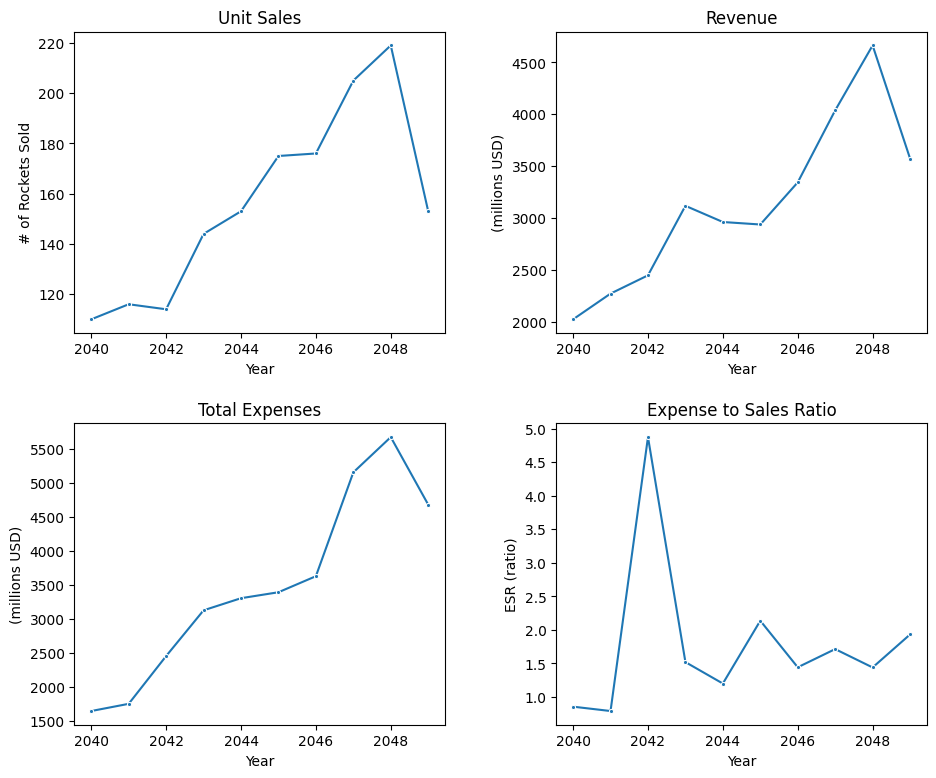

In [18]:
#Annual Trends - Total Aggregation

annual_df = df.groupby('Year')[['Rockets Sold', 'Production Expense', 'Sales Commission Paid',
                          'Total Expenses', 'Revenue', 'Gross Profit']].sum().reset_index()

fig, axs = plt.subplots(2,2, figsize=(11,9))
for i, col in enumerate(sales_num_col1):
  g = sns.lineplot(data = annual_df, x='Year', y=col, marker='.', ax=axs.flat[i])
  g.set_title(col)
  if col == 'Rockets Sold':
    g.set_title('Unit Sales')
    g.set_ylabel('# of Rockets Sold')
  if annual_df[col].max() > 1e6:
    scale_y = 1e6
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    g.yaxis.set_major_formatter(ticks_y)
    g.set_ylabel('(millions USD)')

esr_df = df.groupby('Year').mean()['ESR'].reset_index()
g = sns.lineplot(data = esr_df, x='Year', y='ESR', marker='.', ax=axs.flat[3])
g.set_title('Expense to Sales Ratio')
g.set_ylabel('ESR (ratio)')


plt.subplots_adjust(hspace = 0.3, wspace=0.3)

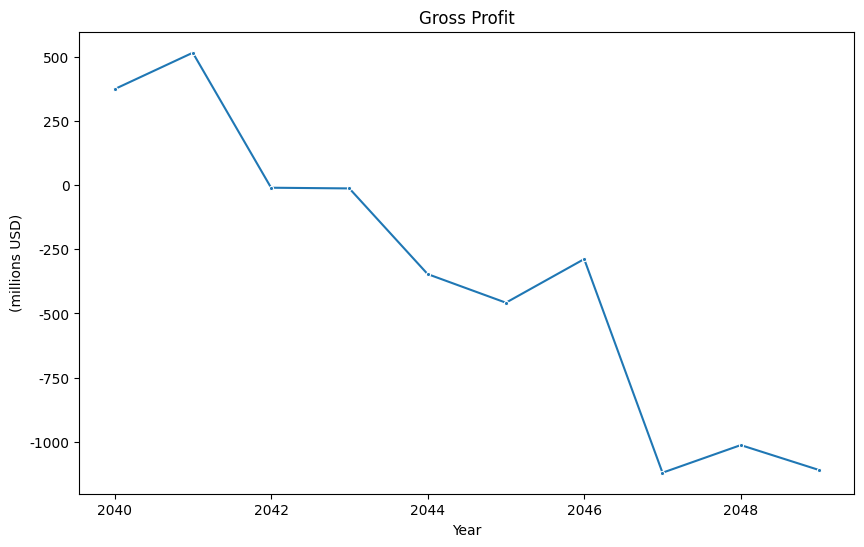

In [19]:
fig, axs = plt.subplots(1, figsize=(10,6))

g = sns.lineplot(data = annual_df, x='Year', y='Gross Profit', marker='.')
g.set_title('Gross Profit')
if annual_df[col].max() > 1e6:
  scale_y = 1e6
  ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
  g.yaxis.set_major_formatter(ticks_y)
  g.set_ylabel('(millions USD)')

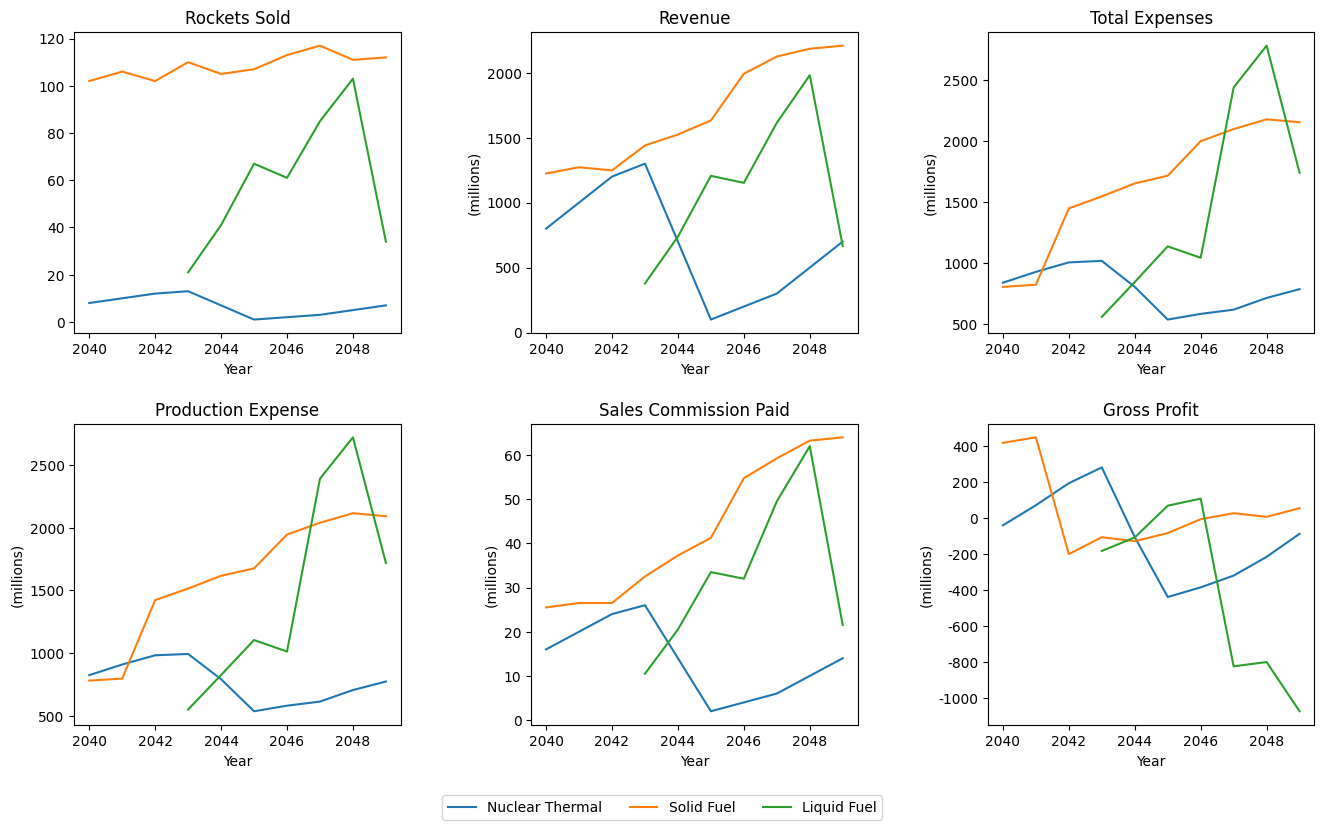

In [20]:
#Annual Trends - Segmentation (Rocket Type)

rocket_type = list(df['Rocket Type'].unique())
num_rt = len(df['Rocket Type'].unique())
annual_rt = df.groupby(['Year', 'Rocket Type'])[['Rockets Sold', 'Revenue', 'Total Expenses',
                                                 'Production Expense', 'Sales Commission Paid', 'Gross Profit']].sum().reset_index()

import matplotlib.ticker as ticker

fig, axs = plt.subplots(2,3, figsize=(16,9))

for i, col in enumerate(sales_num_col):
  g = sns.lineplot(data = annual_rt, x='Year', y=col, hue='Rocket Type', ax=axs.flat[i])
  g.set_ylabel('')
  g.legend().set_visible(False)
  g.set_title(col)
  if annual_df[col].max() > 1e6:
    scale_y = 1e6
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    g.yaxis.set_major_formatter(ticks_y)
    g.set_ylabel('(millions)')

handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=num_rt)
plt.subplots_adjust(hspace = 0.3, wspace=0.4)

Text(0, 0.5, 'ESR')

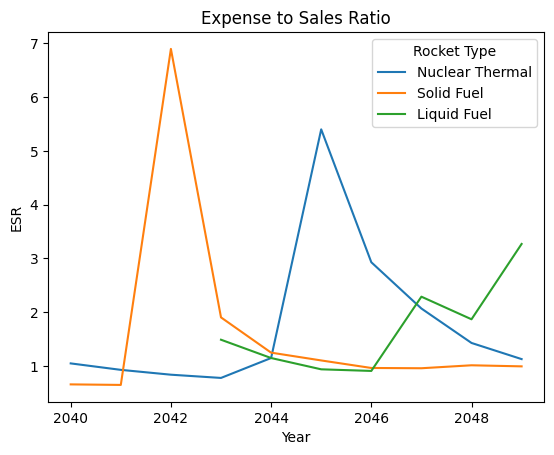

In [21]:
esr_df = df.groupby(['Year', 'Rocket Type']).mean()['ESR'].reset_index()
g = sns.lineplot(data = esr_df, x='Year', y='ESR', hue='Rocket Type')
g.set_title('Expense to Sales Ratio')
g.set_ylabel('ESR')

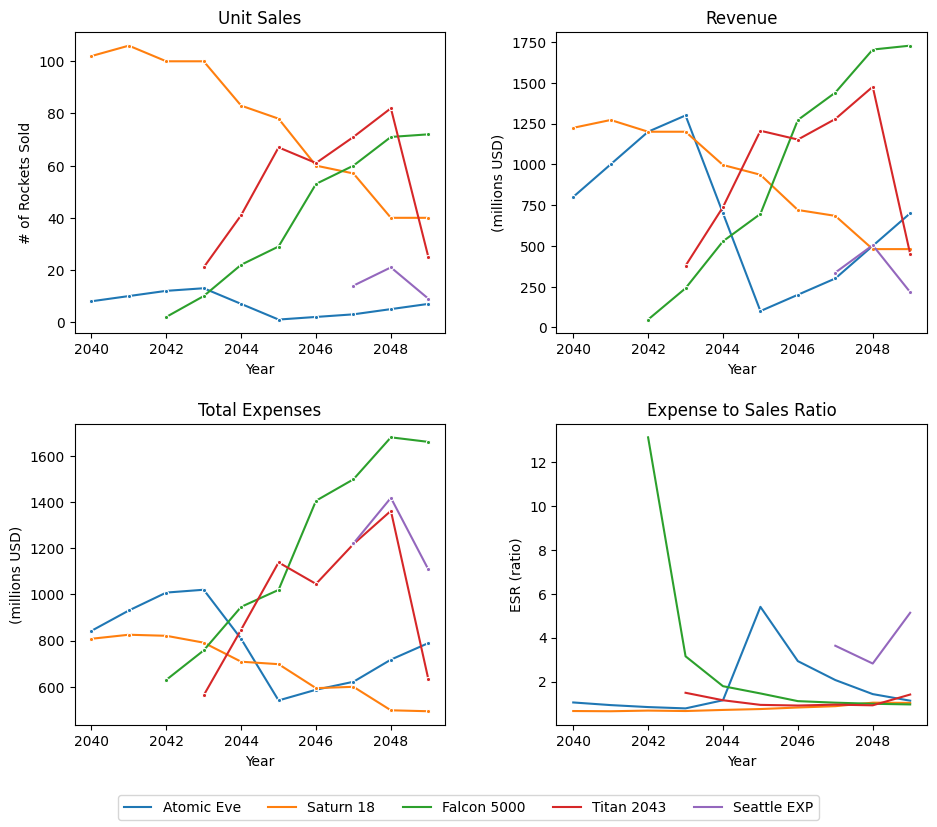

In [22]:
#Annual Trends - Segmentation (Rocket Model)
rocket_models = list(df['Rocket Model'].unique())
num_rm = len(df['Rocket Model'].unique())
annual_rm = df.groupby(['Year', 'Rocket Model'])[['Rockets Sold', 'Revenue', 'Total Expenses',
                                                  'Production Expense', 'Sales Commission Paid', 'Gross Profit']].sum().reset_index()

fig, axs = plt.subplots(2,2, figsize=(11,9))
for i, col in enumerate(sales_num_col1):
  g = sns.lineplot(data = annual_rm, x='Year', y=col, hue='Rocket Model', marker='.', ax=axs.flat[i])
  g.set_title(col)
  if col == 'Rockets Sold':
    g.set_title('Unit Sales')
    g.set_ylabel('# of Rockets Sold')
  g.legend().set_visible(False)
  if annual_df[col].max() > 1e6:
    scale_y = 1e6
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
    g.yaxis.set_major_formatter(ticks_y)
    g.set_ylabel('(millions USD)')

esr_df = df.groupby(['Year', 'Rocket Model']).mean()['ESR'].reset_index()
g = sns.lineplot(data = esr_df, x='Year', y='ESR', hue='Rocket Model')
g.set_title('Expense to Sales Ratio')
g.set_ylabel('ESR (ratio)')
g.legend().set_visible(False)

handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=num_rm)
plt.subplots_adjust(hspace = 0.3, wspace=0.3)

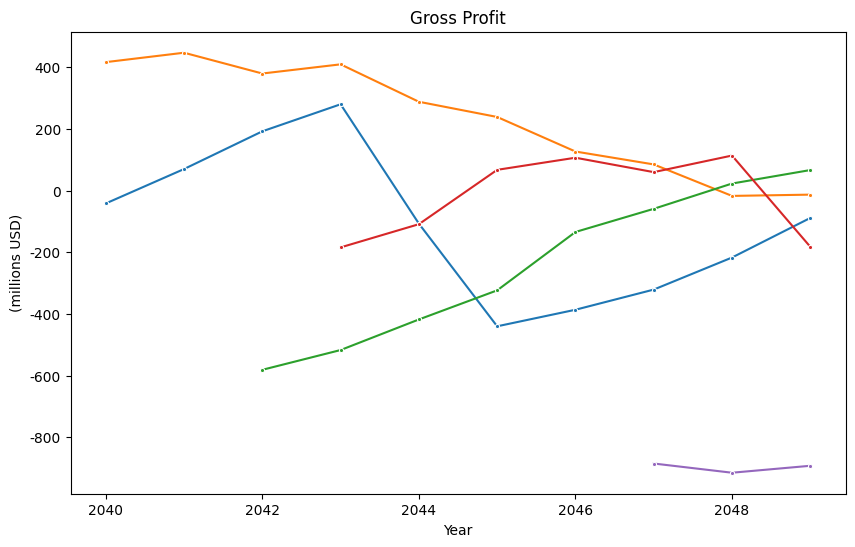

In [23]:
fig, axs = plt.subplots(1, figsize=(10,6))

g = sns.lineplot(data = annual_rm, x='Year', y='Gross Profit', hue='Rocket Model', marker='.')
g.set_title('Gross Profit')
g.legend().set_visible(False)
if annual_df[col].max() > 1e6:
  scale_y = 1e6
  ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
  g.yaxis.set_major_formatter(ticks_y)
  g.set_ylabel('(millions USD)')

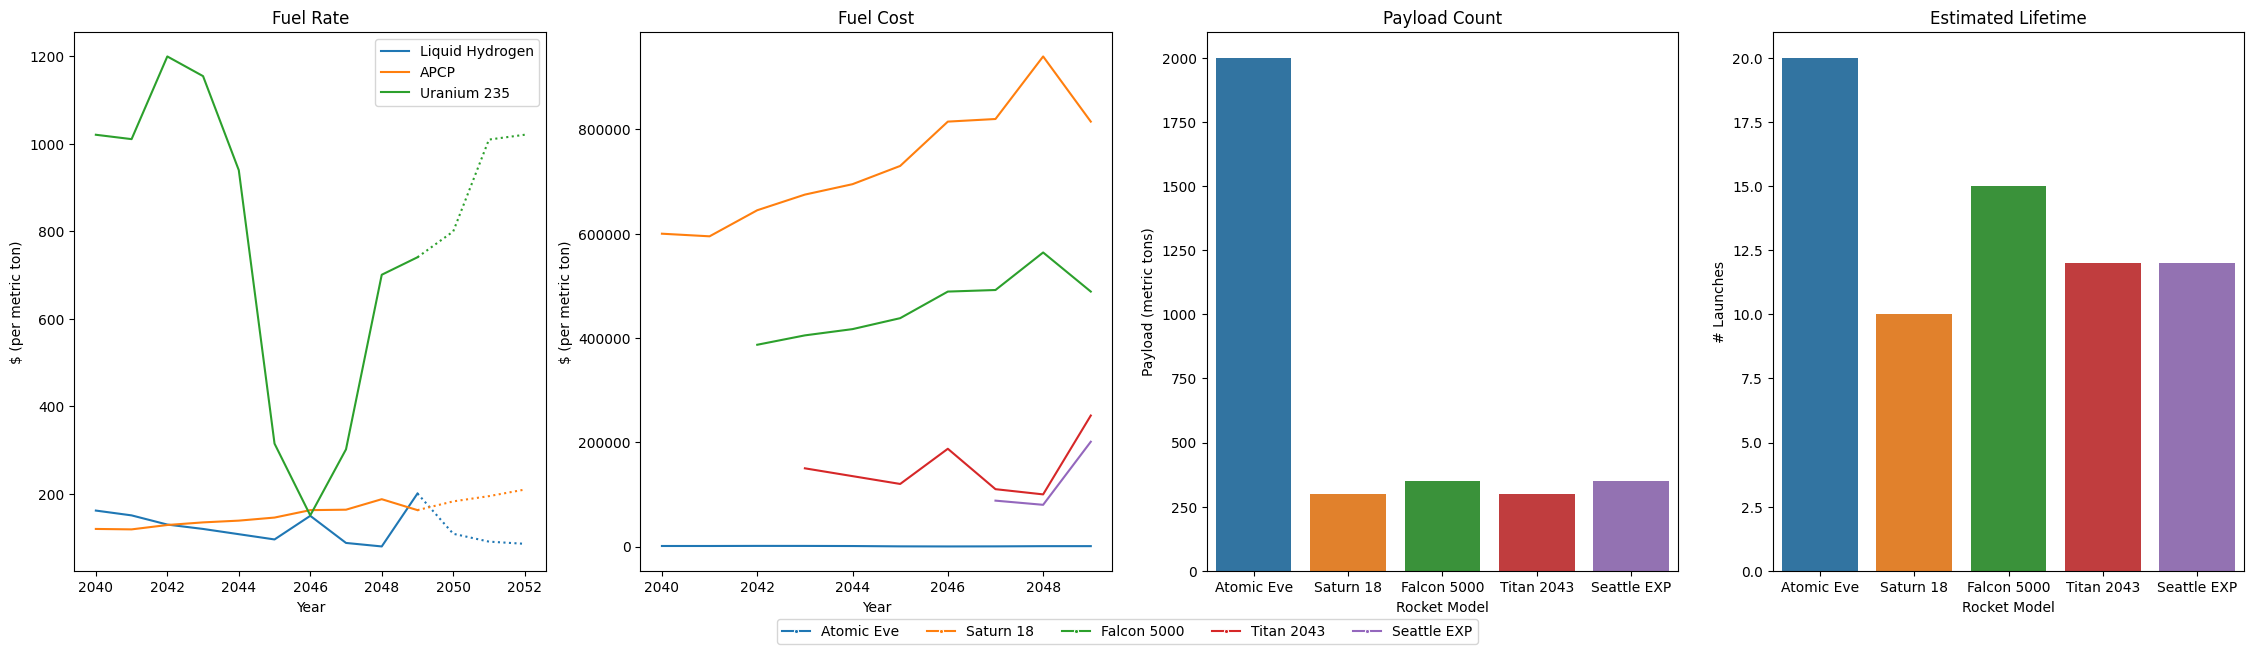

In [24]:
#Product Efficiency Trends
product_df1 = product_df.apply(np.roll, shift=1)
eff_col = ['Fuel Rate', 'Fuel Cost', 'Payload Cost']
num_rm = len(df['Rocket Model'].unique())
eff_df = df[['Year', 'Rocket Model', 'Fuel Rate', 'Fuel Cost', 'Payload Cost']]
eff_df = eff_df.groupby(['Year', 'Rocket Model']).mean('Fuel Rate', 'Fuel Cost', 'Payload Cost')
curr_fuel = fuel_df1.loc[fuel_df1['Year'] <= 2049, :]
fut_fuel = fuel_df1.loc[fuel_df1['Year'] >= 2049, :]

fig, axs = plt.subplots(1,4, figsize=(28,7))

#Fuel Rate
a = sns.lineplot(curr_fuel, x='Year', y='Fuel Rate', hue='Fuel Type', ax=axs.flat[0])
handles, labels = a.get_legend_handles_labels()
b = sns.lineplot(fut_fuel, x='Year', y='Fuel Rate', hue='Fuel Type', linestyle='dotted', ax=axs.flat[0])
axs[0].legend(handles, labels)
a.set_ylabel('$ (per metric ton)')
a.set_title('Fuel Rate')

#Fuel Cost
c = sns.lineplot(eff_df, x='Year', y='Fuel Cost', hue='Rocket Model', ax=axs.flat[1])
c.set_ylabel('$ (per metric ton)')
c.legend().set_visible(False)
c.set_title('Fuel Cost')

#Payload Count
d = sns.barplot(data=product_df1, x='Rocket Model', y='Payload', palette='tab10', ax=axs.flat[2])
d.set_ylabel('Payload (metric tons)')
d.set_title('Payload Count')

#Estimated Lifetime
e = sns.barplot(data=product_df1, x='Rocket Model', y='Est. Lifetime (# Launches)', palette='tab10', ax=axs.flat[3])
e.set_ylabel('# Launches')
e.set_title('Estimated Lifetime')


handles, labels = g.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=num_rm)
plt.subplots_adjust(hspace = 0.3, wspace=0.2)

In [25]:
# Growth Rate for Projected Fuel Costs
fut_fuel['Pct Change'] = round(fut_fuel.groupby('Fuel Type')['Fuel Rate'].pct_change() * 100, 2)
fut_fuel_avg = fut_fuel.groupby('Fuel Type')['Pct Change'].mean().round(2).sort_values(ascending=False).reset_index().rename(columns={'Pct Change': 'Avg Pct Change (Projected Cost)'})
fut_fuel_avg

,Fuel Type,Avg Pct Change (Projected Cost)
0,Uranium 235,11.77
1,APCP,8.84
2,Liquid Hydrogen,-22.59


In [26]:
# Sales Commission Rate by Product
product_df['Sales Commission Rate (%)'] = round(product_df['Rocket Salesperson Bonus Per Sale'] / product_df['Sale Price'] * 100, 2)
sales_commission_df = product_df[['Rocket Model', 'Sale Price', 'Sales Commission Rate (%)']].sort_values('Sales Commission Rate (%)', ascending=False)
sales_commission_df

,Rocket Model,Sale Price,Sales Commission Rate (%)
3,Seattle EXP,24000000,4.17
1,Falcon 5000,24000000,3.12
2,Titan 2043,18000000,2.78
0,Saturn 18,12000000,2.08
4,Atomic Eve,100000000,2.00


## Calculations

In [27]:
annual_pct = df.groupby('Year').sum()[['Rockets Sold', 'Revenue', 'Total Expenses', 'Gross Profit']].reset_index()
annual_pct['RS Pct Change'] = round(annual_pct['Rockets Sold'].diff() / annual_pct['Rockets Sold'].abs().shift() * 100, 2)
annual_pct['Rev Pct Change'] = round(annual_pct['Revenue'].diff() / annual_pct['Revenue'].abs().shift() * 100, 2)
annual_pct['TE Pct Change'] = round(annual_pct['Total Expenses'].diff() / annual_pct['Total Expenses'].abs().shift() * 100, 2)
annual_pct['GP Pct Change'] = round(annual_pct['Gross Profit'].diff() / annual_pct['Gross Profit'].abs().shift() * 100, 2)
annual_pct

,Year,Rockets Sold,Revenue,Total Expenses,Gross Profit,RS Pct Change,Rev Pct Change,TE Pct Change,GP Pct Change
0,2040,110,2024000000,1649449036,374550964,NaN,NaN,NaN,NaN
1,2041,116,2272000000,1755326748,516673252,5.45,12.25,6.42,37.94
2,2042,114,2448000000,2457717692,-9717692,-1.72,7.75,40.01,-101.88
3,2043,144,3118000000,3130446134,-12446134,26.32,27.37,27.37,-28.08
4,2044,153,2962000000,3308511675,-346511675,6.25,-5.00,5.69,-2684.09
5,2045,175,2938000000,3396057508,-458057508,14.38,-0.81,2.65,-32.19
6,2046,176,3344000000,3631875736,-287875736,0.57,13.82,6.94,37.15
7,2047,205,4038000000,5159011242,-1121011242,16.48,20.75,42.05,-289.41
8,2048,219,4664000000,5677274732,-1013274732,6.83,15.50,10.05,9.61
9,2049,153,3574000000,4684471890,-1110471890,-30.14,-23.37,-17.49,-9.59


In [28]:
annual_gp = df.groupby('Year').sum()['Gross Profit'].reset_index()
annual_gp['Pct Change'] = round(annual_gp['Gross Profit'].diff() / annual_gp['Gross Profit'].abs().shift() * 100, 2)
avg_gp_yoy = round(annual_gp['Pct Change'].mean(), 2)

print(f'Average Gross Profit Growth Rate (YOY): {avg_gp_yoy}%')

Average Gross Profit Growth Rate (YOY): -340.06%


In [29]:
annual_ae = annual_rm.loc[annual_rm['Rocket Model'] == 'Atomic Eve', ['Year', 'Gross Profit']]
annual_ae['GP Pct Change'] = (annual_ae['Gross Profit'].diff() / annual_ae['Gross Profit'].abs().shift() * 100)
avg_ae_gp1 = round(annual_ae.loc[annual_ae['Year'].between(2044, 2045)]['GP Pct Change'].mean(), 2)

print(f'Product AE, Average Gross Profit Growth Rate (2044-2045): {avg_ae_gp1}%')

Product AE, Average Gross Profit Growth Rate (2044-2045): -224.3%


In [30]:
annual_sea = annual_rm.loc[annual_rm['Rocket Model'] == 'Seattle EXP', ['Year', 'Total Expenses', 'Gross Profit']]
avg_sea_gp1 = round(annual_sea['Gross Profit'].mean(), 2)
avg_sea_te1 = round(annual_sea['Total Expenses'].mean(), 2)

print(f'Product SEA, Average Gross Profit (2047-2049): ${avg_sea_gp1:,}')
print(f'Product SEA, Average Total Expenses (2047-2049): ${avg_sea_te1:,}')

Product SEA, Average Gross Profit (2047-2049): $-897,491,748.33
Product SEA, Average Total Expenses (2047-2049): $1,249,491,748.33


In [31]:
annual_s18 = annual_rm.loc[annual_rm['Rocket Model'] == 'Saturn 18', ['Year','Rockets Sold', 'Gross Profit']]
avg_sales_yoy = round(annual_s18['Rockets Sold'].pct_change().mean()*100, 2)
avg_s18_gp_yoy = round((annual_s18['Gross Profit'].diff() / annual_s18['Gross Profit'].abs().shift() * 100).mean(), 2)

print(f'Average "Saturn 18" Sales Rate (YOY): {avg_sales_yoy}%')
print(f'Average "Saturn 18" Gross Profit (YOY): {avg_s18_gp_yoy}%')

Average "Saturn 18" Sales Rate (YOY): -9.18%
Average "Saturn 18" Gross Profit (YOY): -24.83%


In [32]:
annual_ae_esr = esr_df.loc[esr_df['Rocket Model'] == 'Atomic Eve']
annual_ae_esr['ESR Pct Chg'] = round(esr_df.loc[esr_df['Rocket Model'] == 'Atomic Eve']['ESR'].pct_change() * 100, 2)
ae_esr_2045_chg = annual_ae_esr.loc[annual_ae_esr['Year'] == 2045, 'ESR Pct Chg'].item()

print(f'ESR Percent Change (2045): {ae_esr_2045_chg}%')

ESR Percent Change (2045): 369.57%


In [33]:
annual_sea_pe = annual_rm.loc[annual_rm['Rocket Model'] == 'Seattle EXP', ['Production Expense']].mean().item()
annual_rm_pe = annual_rm['Production Expense'].mean()
avg_sea_avg_pe_ratio = round(((annual_sea_pe - annual_rm_pe)/annual_rm_pe * 100), 2)

print(f'Average Seattle EXP/Annual Production Expense Ratio: {avg_sea_avg_pe_ratio}%')

Average Seattle EXP/Annual Production Expense Ratio: 37.79%
